In [156]:
%%capture
%pip install autogluon

In [157]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import autogluon

In [158]:
train = pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv')
train.drop(columns=['id'], axis=1, inplace=True)

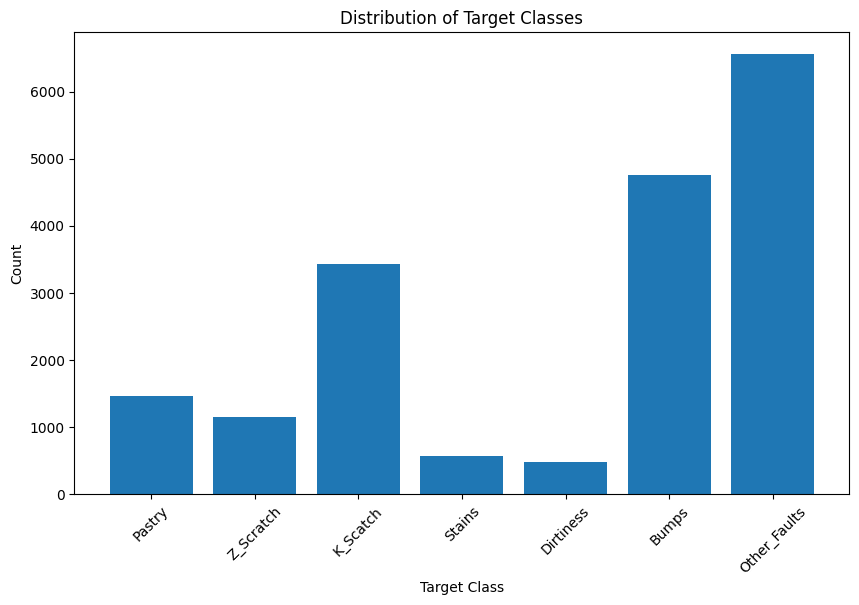

In [159]:
target_cols = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults']

# Calculate counts for each target class
class_counts = train[target_cols].sum()

# Plot the distribution of each target class
plt.figure(figsize=(10, 6))
plt.bar(x=class_counts.index, height=class_counts.values)
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.title('Distribution of Target Classes')
plt.xticks(rotation=45)
plt.show()

In [160]:
multi_label_rows = train[train[target_cols].sum(axis=1) > 1]
no_target = train[train[target_cols].sum(axis=1) == 0]
indices_to_drop = np.concatenate([multi_label_rows.index.values, no_target.index.values])
experiment = train.drop(labels=indices_to_drop, axis=0)

Top Feature Subsets based on Importance:
                  Feature  Importance
17        Outside_X_Index    0.064594
4            Pixels_Areas    0.063081
21             LogOfAreas    0.058557
22            Log_X_Index    0.055384
7       Sum_of_Luminosity    0.048717
5             X_Perimeter    0.047880
8   Minimum_of_Luminosity    0.042505
10     Length_of_Conveyer    0.042210
0               X_Minimum    0.040206
25       Luminosity_Index    0.039337


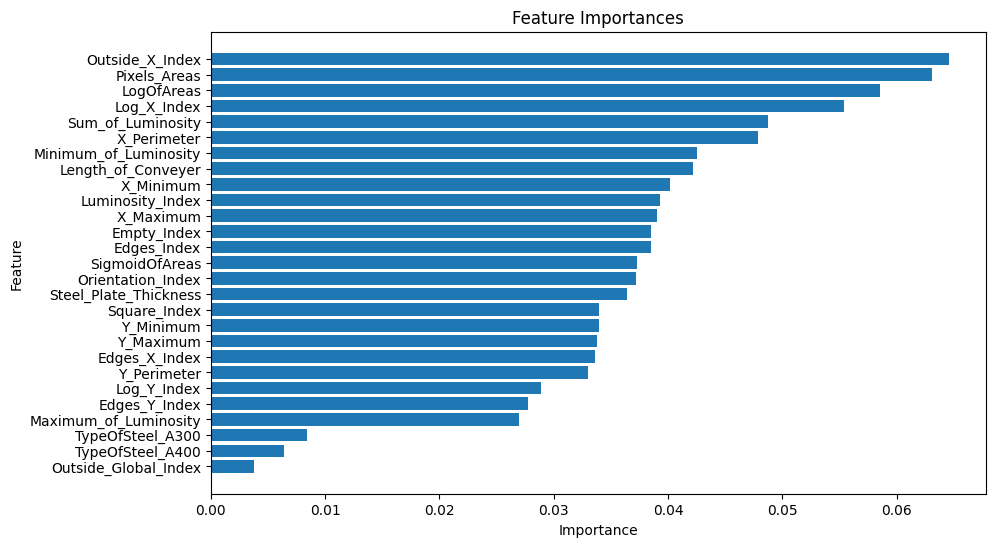

In [161]:
from sklearn.ensemble import RandomForestClassifier


# Assuming you already have multi_label_rows and no_target DataFrames

# Concatenate the DataFrames
indices_to_drop_df = pd.concat([multi_label_rows, no_target])

# Drop the target columns
indices_to_drop_df = indices_to_drop_df.drop(columns=target_cols)

# Separate features and target
X_train = train.drop(columns=target_cols, axis=1)
y_train = train[target_cols]

# Fit RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Predict labels for indices to drop
labels = rf.predict(indices_to_drop_df)

# Extract feature importances
importances = rf.feature_importances_

# Combine feature names and importances into a DataFrame
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort feature importance values
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display top feature subsets based on importance
print("Top Feature Subsets based on Importance:")
print(feature_importance_df.head(10))

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()

## Permutation 

In [ ]:
from sklearn.inspection import permutation_importance


# Compute permutation importances
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# Extract the importances
importances = result.importances_mean

# Now you can use 'importances' to analyze feature importance
# Some of the columns showed 0 importances and for that reason are disgarded for dimensionality reduction

In [162]:
train.loc[indices_to_drop_df.index, target_cols] = 0

# Step 2: Impute predicted labels for indices to drop
train.loc[indices_to_drop_df.index, target_cols] = labels

## Add the original data

In [163]:
d = pd.read_csv('/kaggle/input/faulty-steel-plates/faults.csv')
train = pd.concat([d, train], axis=0)
train.drop(columns=['Y_Maximum','Y_Minimum',
         'SigmoidOfAreas','Edges_X_Index',
         'Sum_of_Luminosity','X_Perimeter'
        ], axis=1, inplace=True)


##  Scaler

In [164]:
scaler = StandardScaler()
numerical_cols = ['TypeOfSTeel_A300', 'TypeOfSteel_A400']
continuos_cols = [col for col in train.columns if col not in numerical_cols + target_cols]

train[continuos_cols] = scaler.fit_transform(train[continuos_cols])
test[continuos_cols] = scaler.transform(test[continuos_cols])

# MultiLabel autogluon class

In [165]:
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common.utils.utils import setup_outputdir
from autogluon.core.utils.loaders import load_pkl
from autogluon.core.utils.savers import save_pkl
import os.path

class MultilabelPredictor():
    """ Tabular Predictor for predicting multiple columns in table.
        Creates multiple TabularPredictor objects which you can also use individually.
        You can access the TabularPredictor for a particular label via: `multilabel_predictor.get_predictor(label_i)`

        Parameters
        ----------
        labels : List[str]
            The ith element of this list is the column (i.e. `label`) predicted by the ith TabularPredictor stored in this object.
        path : str, default = None
            Path to directory where models and intermediate outputs should be saved.
            If unspecified, a time-stamped folder called "AutogluonModels/ag-[TIMESTAMP]" will be created in the working directory to store all models.
            Note: To call `fit()` twice and save all results of each fit, you must specify different `path` locations or don't specify `path` at all.
            Otherwise files from first `fit()` will be overwritten by second `fit()`.
            Caution: when predicting many labels, this directory may grow large as it needs to store many TabularPredictors.
        problem_types : List[str], default = None
            The ith element is the `problem_type` for the ith TabularPredictor stored in this object.
        eval_metrics : List[str], default = None
            The ith element is the `eval_metric` for the ith TabularPredictor stored in this object.
        consider_labels_correlation : bool, default = True
            Whether the predictions of multiple labels should account for label correlations or predict each label independently of the others.
            If True, the ordering of `labels` may affect resulting accuracy as each label is predicted conditional on the previous labels appearing earlier in this list (i.e. in an auto-regressive fashion).
            Set to False if during inference you may want to individually use just the ith TabularPredictor without predicting all the other labels.
        kwargs :
            Arguments passed into the initialization of each TabularPredictor.

    """

    multi_predictor_file = 'multilabel_predictor.pkl'

    def __init__(self, labels, path=None, problem_types=None, eval_metrics=None, consider_labels_correlation=True, **kwargs):
        if len(labels) < 2:
            raise ValueError("MultilabelPredictor is only intended for predicting MULTIPLE labels (columns), use TabularPredictor for predicting one label (column).")
        if (problem_types is not None) and (len(problem_types) != len(labels)):
            raise ValueError("If provided, `problem_types` must have same length as `labels`")
        if (eval_metrics is not None) and (len(eval_metrics) != len(labels)):
            raise ValueError("If provided, `eval_metrics` must have same length as `labels`")
        self.path = setup_outputdir(path, warn_if_exist=False)
        self.labels = labels
        self.consider_labels_correlation = consider_labels_correlation
        self.predictors = {}  # key = label, value = TabularPredictor or str path to the TabularPredictor for this label
        if eval_metrics is None:
            self.eval_metrics = {}
        else:
            self.eval_metrics = {labels[i] : eval_metrics[i] for i in range(len(labels))}
        problem_type = None
        eval_metric = None
        for i in range(len(labels)):
            label = labels[i]
            path_i = self.path + "Predictor_" + label
            if problem_types is not None:
                problem_type = problem_types[i]
            if eval_metrics is not None:
                eval_metric = eval_metrics[i]
            self.predictors[label] = TabularPredictor(label=label, problem_type=problem_type, eval_metric=eval_metric, path=path_i, **kwargs)

    def fit(self, train_data, tuning_data=None, **kwargs):
        """ Fits a separate TabularPredictor to predict each of the labels.

            Parameters
            ----------
            train_data, tuning_data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                See documentation for `TabularPredictor.fit()`.
            kwargs :
                Arguments passed into the `fit()` call for each TabularPredictor.
        """
        if isinstance(train_data, str):
            train_data = TabularDataset(train_data)
        if tuning_data is not None and isinstance(tuning_data, str):
            tuning_data = TabularDataset(tuning_data)
        train_data_og = train_data.copy()
        if tuning_data is not None:
            tuning_data_og = tuning_data.copy()
        else:
            tuning_data_og = None
        save_metrics = len(self.eval_metrics) == 0
        for i in range(len(self.labels)):
            label = self.labels[i]
            predictor = self.get_predictor(label)
            if not self.consider_labels_correlation:
                labels_to_drop = [l for l in self.labels if l != label]
            else:
                labels_to_drop = [self.labels[j] for j in range(i+1, len(self.labels))]
            train_data = train_data_og.drop(labels_to_drop, axis=1)
            if tuning_data is not None:
                tuning_data = tuning_data_og.drop(labels_to_drop, axis=1)
            print(f"Fitting TabularPredictor for label: {label} ...")
            predictor.fit(train_data=train_data, tuning_data=tuning_data, **kwargs)
            self.predictors[label] = predictor.path
            if save_metrics:
                self.eval_metrics[label] = predictor.eval_metric
        self.save()

    def predict(self, data, **kwargs):
        """ Returns DataFrame with label columns containing predictions for each label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. If label columns are present in this data, they will be ignored. See documentation for `TabularPredictor.predict()`.
            kwargs :
                Arguments passed into the predict() call for each TabularPredictor.
        """
        return self._predict(data, as_proba=False, **kwargs)

    def predict_proba(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `predict_proba()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. See documentation for `TabularPredictor.predict()` and `TabularPredictor.predict_proba()`.
            kwargs :
                Arguments passed into the `predict_proba()` call for each TabularPredictor (also passed into a `predict()` call).
        """
        return self._predict(data, as_proba=True, **kwargs)

    def evaluate(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `evaluate()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to evalate predictions of all labels for, must contain all labels as columns. See documentation for `TabularPredictor.evaluate()`.
            kwargs :
                Arguments passed into the `evaluate()` call for each TabularPredictor (also passed into the `predict()` call).
        """
        data = self._get_data(data)
        eval_dict = {}
        for label in self.labels:
            print(f"Evaluating TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            eval_dict[label] = predictor.evaluate(data, **kwargs)
            if self.consider_labels_correlation:
                data[label] = predictor.predict(data, **kwargs)
        return eval_dict

    def save(self):
        """ Save MultilabelPredictor to disk. """
        for label in self.labels:
            if not isinstance(self.predictors[label], str):
                self.predictors[label] = self.predictors[label].path
        save_pkl.save(path=self.path+self.multi_predictor_file, object=self)
        print(f"MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('{self.path}')")

    @classmethod
    def load(cls, path):
        """ Load MultilabelPredictor from disk `path` previously specified when creating this MultilabelPredictor. """
        path = os.path.expanduser(path)
        if path[-1] != os.path.sep:
            path = path + os.path.sep
        return load_pkl.load(path=path+cls.multi_predictor_file)

    def get_predictor(self, label):
        """ Returns TabularPredictor which is used to predict this label. """
        predictor = self.predictors[label]
        if isinstance(predictor, str):
            return TabularPredictor.load(path=predictor)
        return predictor

    def _get_data(self, data):
        if isinstance(data, str):
            return TabularDataset(data)
        return data.copy()

    def _predict(self, data, as_proba=False, **kwargs):
        data = self._get_data(data)
        if as_proba:
            predproba_dict = {}
        for label in self.labels:
            print(f"Predicting with TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            if as_proba:
                predproba_dict[label] = predictor.predict_proba(data, as_multiclass=True, **kwargs)
            data[label] = predictor.predict(data, **kwargs)
        if not as_proba:
            return data[self.labels]
        else:
            return predproba_dict

In [166]:
from autogluon.tabular import TabularDataset, TabularPredictor

multi_predictor = MultilabelPredictor(labels=target_cols, problem_types=['binary', 'binary', 'binary', 'binary', 'binary', 'binary', 'binary'], eval_metrics=['accuracy', 'accuracy', 'accuracy', 'accuracy', 'accuracy', 'accuracy', 'accuracy'])
multi_predictor.fit(train, time_limit=700, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20240329_182031"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 700 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240329_182031Predictor_Pastry/ds_sub_fit/sub_fit_ho.


Fitting TabularPredictor for label: Pastry ...


2024-03-29 18:20:31,918	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
Beginning AutoGluon training ... Time limit = 175s
AutoGluon will save models to "AutogluonModels/ag-20240329_182031Predictor_Pastry/ds_sub_fit/sub_fit_ho"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Dec 19 13:14:11 UTC 2023
CPU Count:          4
Memory Avail:       29.30 GB / 31.36 GB (93.4%)
Disk Space Avail:   15.36 GB / 19.52 GB (78.7%)
Train Data Rows:    18808
Train Data Columns: 21
Label Column:       Pastry
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:          

Fitting TabularPredictor for label: Z_Scratch ...


Spend 201 seconds for the sub-fit(s) during dynamic stacking.
Time left for full fit of AutoGluon: 499 seconds.
Starting full fit now with num_stack_levels 1.
Beginning AutoGluon training ... Time limit = 499s
AutoGluon will save models to "AutogluonModels/ag-20240329_182031Predictor_Z_Scratch"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Dec 19 13:14:11 UTC 2023
CPU Count:          4
Memory Avail:       28.33 GB / 31.36 GB (90.3%)
Disk Space Avail:   14.73 GB / 19.52 GB (75.4%)
Train Data Rows:    21160
Train Data Columns: 22
Label Column:       Z_Scratch
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    29010.08 MB
	Train Data (Original)  Memory Usage:

Fitting TabularPredictor for label: K_Scatch ...


Spend 198 seconds for the sub-fit(s) during dynamic stacking.
Time left for full fit of AutoGluon: 502 seconds.
Starting full fit now with num_stack_levels 0.
Beginning AutoGluon training ... Time limit = 502s
AutoGluon will save models to "AutogluonModels/ag-20240329_182031Predictor_K_Scatch"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Dec 19 13:14:11 UTC 2023
CPU Count:          4
Memory Avail:       28.27 GB / 31.36 GB (90.2%)
Disk Space Avail:   14.33 GB / 19.52 GB (73.4%)
Train Data Rows:    21160
Train Data Columns: 23
Label Column:       K_Scatch
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    28952.97 MB
	Train Data (Original)  Memory Usage: 3

Fitting TabularPredictor for label: Stains ...


Spend 204 seconds for the sub-fit(s) during dynamic stacking.
Time left for full fit of AutoGluon: 496 seconds.
Starting full fit now with num_stack_levels 1.
Beginning AutoGluon training ... Time limit = 496s
AutoGluon will save models to "AutogluonModels/ag-20240329_182031Predictor_Stains"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Dec 19 13:14:11 UTC 2023
CPU Count:          4
Memory Avail:       28.33 GB / 31.36 GB (90.3%)
Disk Space Avail:   14.09 GB / 19.52 GB (72.2%)
Train Data Rows:    21160
Train Data Columns: 24
Label Column:       Stains
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    29012.96 MB
	Train Data (Original)  Memory Usage: 3.87 

Fitting TabularPredictor for label: Dirtiness ...


Spend 191 seconds for the sub-fit(s) during dynamic stacking.
Time left for full fit of AutoGluon: 509 seconds.
Starting full fit now with num_stack_levels 1.
Beginning AutoGluon training ... Time limit = 509s
AutoGluon will save models to "AutogluonModels/ag-20240329_182031Predictor_Dirtiness"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Dec 19 13:14:11 UTC 2023
CPU Count:          4
Memory Avail:       28.24 GB / 31.36 GB (90.1%)
Disk Space Avail:   13.93 GB / 19.52 GB (71.4%)
Train Data Rows:    21160
Train Data Columns: 25
Label Column:       Dirtiness
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    28923.08 MB
	Train Data (Original)  Memory Usage:

Fitting TabularPredictor for label: Bumps ...


Spend 199 seconds for the sub-fit(s) during dynamic stacking.
Time left for full fit of AutoGluon: 501 seconds.
Starting full fit now with num_stack_levels 0.
Beginning AutoGluon training ... Time limit = 501s
AutoGluon will save models to "AutogluonModels/ag-20240329_182031Predictor_Bumps"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Dec 19 13:14:11 UTC 2023
CPU Count:          4
Memory Avail:       28.10 GB / 31.36 GB (89.6%)
Disk Space Avail:   13.64 GB / 19.52 GB (69.9%)
Train Data Rows:    21160
Train Data Columns: 26
Label Column:       Bumps
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    28783.63 MB
	Train Data (Original)  Memory Usage: 4.20 MB

Fitting TabularPredictor for label: Other_Faults ...


Spend 191 seconds for the sub-fit(s) during dynamic stacking.
Time left for full fit of AutoGluon: 509 seconds.
Starting full fit now with num_stack_levels 1.
Beginning AutoGluon training ... Time limit = 509s
AutoGluon will save models to "AutogluonModels/ag-20240329_182031Predictor_Other_Faults"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Dec 19 13:14:11 UTC 2023
CPU Count:          4
Memory Avail:       28.15 GB / 31.36 GB (89.8%)
Disk Space Avail:   13.00 GB / 19.52 GB (66.6%)
Train Data Rows:    21160
Train Data Columns: 27
Label Column:       Other_Faults
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    28830.14 MB
	Train Data (Original)  Memory 

MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/ag-20240329_182031')


In [167]:
# If you want metrics you must split your training data and then evaluate on the unseen val data here
"""
evaluations = multi_predictor.evaluate(val)
print(evaluations)
print("Evaluated using metrics:", multi_predictor.eval_metrics)
"""

'\nevaluations = multi_predictor.evaluate(val)\nprint(evaluations)\nprint("Evaluated using metrics:", multi_predictor.eval_metrics)\n'

In [176]:
predictions = multi_predictor.predict_proba(test.drop(columns=['id'], axis=1))

Predicting with TabularPredictor for label: Pastry ...


INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Predicting with TabularPredictor for label: Z_Scratch ...


INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Predicting with TabularPredictor for label: K_Scatch ...
Predicting with TabularPredictor for label: Stains ...


INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Predicting with TabularPredictor for label: Dirtiness ...


INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Predicting with TabularPredictor for label: Bumps ...
Predicting with TabularPredictor for label: Other_Faults ...


In [177]:

keys = predictions.keys()

# Create a list to store series for each key
series_list = []

# Iterate over keys, create series, and append to the list
for key in keys:
    series = pd.Series(predictions[key][1], name=key)  # Assuming you want the second column from the prediction values
    series_list.append(series)

# Concatenate series into a DataFrame
predictions_df = pd.concat(series_list, axis=1)


In [178]:
ids = test['id']


predictions_df.insert(0, 'id', ids)
predictions_df

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.618780,0.008026,0.002399,0.090974,0.081086,0.003868,0.072443
1,19220,0.295659,0.013387,0.028296,0.101214,0.297439,0.297934,0.796199
2,19221,0.011558,0.031674,0.061031,0.096093,0.080658,0.295811,0.758741
3,19222,0.162900,0.008055,0.000914,0.092494,0.089809,0.404367,0.814412
4,19223,0.013866,0.008093,0.004352,0.101437,0.088956,0.675653,0.072354
...,...,...,...,...,...,...,...,...
12809,32028,0.081690,0.130481,0.002896,0.092345,0.132961,0.302353,0.752690
12810,32029,0.126026,0.008394,0.032623,0.121696,0.301574,0.314376,0.819820
12811,32030,0.011482,0.008020,0.907370,0.093192,0.064248,0.000247,0.075327
12812,32031,0.316049,0.009243,0.043736,0.091756,0.171982,0.305064,0.767232


In [179]:
predictions_df.to_csv('submission.csv', index=False)